# SMA-A3 Post-processing routines

This is a set of routines to prepare the ouptputs to users of SM-A3 ForCoast service module. 

It should be executed after the preparation of Lagrangian tracks (Parcels), once per pollutant sources. 

As such, it should prepare numeric outputs specific to each sources, as well as instance of figures for each specific source. In a later stage, a 'final post-processing script' may  be considered to gather processed infromation from the different sources. 

Basically, in terms of computation the processing should : 
* Get the age distribution of particles within the box at any time step of the lagrangian simulation. 
* Keep a count of particle entering the domain within a day (or an hour)

The outputs consists in 

* Time series of proportion (#particles entering the domain / #particles released from source) reaching the farm before a given Age threshold (or several).
* Based on the above, a flag based on a probability threshold to send a warning.
* Maps of Age distribution (eg. animations) 


## Module load and Specific definition

**TODO**
* fix rules for filenames. 
* Build interface to get user-defined values from somewhere (JSON or Yaml namelists ? ) 

In [8]:
import netCDF4
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from datetime import timedelta as delta

fname = '00000003.nc'

In [9]:
# Extent is jsut the external frame for the maps
## TODO : Should be user-defined, or by default upon user subscription
## For instance consiser large lon/lat extent from source to polygons and extent a frame around that +X°

extent = [28, 29, 43, 44.5]

In [ ]:
thres_Age = 3*24 # hours

In [254]:
poly1 = [[28.6611,44.0435],
             [28.6617,44.0435],
             [28.6617,44.0553],
             [28.6611,44.0553]]

# Todo, build a list of polygons, etc ..

## Functions

In [10]:
# Function to prepare axis for map plots.

import cartopy.crs as ccrs
def start_axes(title, extent=extent, fig=None, sp=None):
    if fig is None:
        fig = plt.figure(figsize=(13, 5))
        
    if sp is None:
        ax = fig.add_axes([0.03, 0.03, 0.90, 0.94],projection=ccrs.PlateCarree())
    else:
        ax = fig.add_subplot(sp,projection=ccrs.PlateCarree())
            
    ax.set_extent(extent)
    ax.gridlines()
    ax.coastlines(resolution='10m')
    #ax.set_xlim(-6, 36.5), ax.set_ylim(30, 46)
    #ax.set_aspect("equal")
    ax.set_title(title)
    ax.gridlines(xlocs=range(25,42,1), ylocs=range(40,48,1),draw_labels=True)#
    return ax

In [178]:
import matplotlib.path as mpltPath

def mplpoly(xin,yin,poly): 
    if (isinstance(xin,np.ndarray))&(len(xin.shape)>1):
        fromarray=True
        x = xin.flatten()
        y = yin.flatten()
    else:
        fromarray=False
        x=xin
        y=yin

    path = mpltPath.Path(poly)
    points=np.array([x, y]).T
    inside = path.contains_points(points)
    
    if fromarray:
        inside= np.reshape(inside, xin.shape)
    return(inside)

## Data Load

In [179]:
data_xarray = xr.open_dataset(fname)
#print(data_xarray)

In [180]:
np.set_printoptions(linewidth=160)
ns_per_hour = np.timedelta64(1, 'h') # nanoseconds in an hour

In [181]:
x = data_xarray['lon'].values
y = data_xarray['lat'].values

distance = np.cumsum(np.sqrt(np.square(np.diff(x))+np.square(np.diff(y))),axis=1)  # d = (dx^2 + dy^2)^(1/2)
real_time = data_xarray['time']

# substract the initial time from each timeseries
time_since_release = (real_time.values.transpose() - real_time.values[:,0])/np.timedelta64(1, 'D') 

In [182]:
outputdt = delta(hours=6)
timerange = np.arange(np.nanmin(data_xarray['time'].values),
                      np.nanmax(data_xarray['time'].values)+np.timedelta64(outputdt), 
                      outputdt) # timerange in nanoseconds

## Level 1 and 2

Compute the number of particles entering the polygon with an age below `thres_Age`.

Save a netcdf with 
* dimensions : (time, #polygon, #release source) 
* variables : 
    * proportion of particles below age threshold entering the polygon
    * lower age (or rather percentile 5%, since te min may be too much affected by a single particle)
    
On the base of this netcdf, build a time series plot. 

In [255]:
points_x = data_xarray['lon'].values
points_y = data_xarray['lat'].values

In [256]:
areinside = mplpoly(points_x,points_y, poly1 )

In [257]:
ageofinside = time_since_release[areinside.T]

### ISSUE

Small problem here, it seems we have only 5 occurence of particle inside the box ? 

Will we need to identify the cases where the line between subsequent positions crosses the polygon ? 

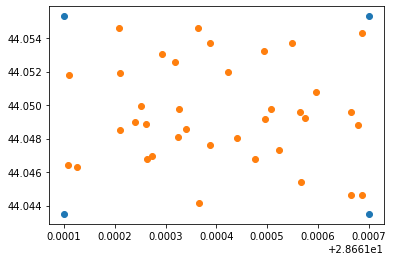

In [258]:
plt.scatter(np.array(poly1)[:,0],np.array(poly1)[:,1] )
plt.scatter(points_x[areinside], points_y[areinside] )

## Level 3

Gif animation.

To be refined ... 

In [236]:
apoly1=np.array(poly1)

ml=np.min(apoly1[:,1])
Ml=np.max(apoly1[:,1])
mL=np.min(apoly1[:,0])
ML=np.max(apoly1[:,0])

extp=[mL-(ML-mL), ML+(ML-mL), ml-(Ml-ml), Ml+(Ml-ml)]

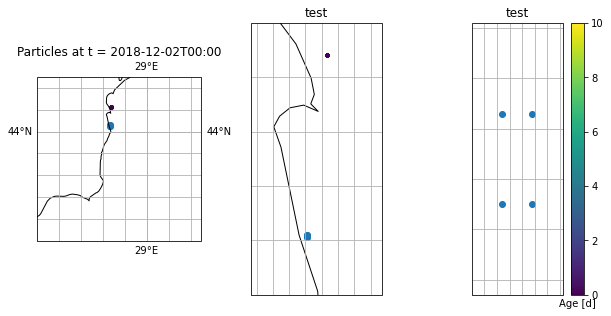

In [237]:
from matplotlib.animation import FuncAnimation

# %%capture
fig = plt.figure(figsize=(10,5))

ax1=start_axes('test', fig=fig,sp='131', extent=[28, 29.5, 43, 44.5])
ax2=start_axes('test', fig=fig,sp='132', extent=[28.61, 28.73, 44.0, 44.25])
ax3=start_axes('test', fig=fig,sp='133', extent=extp)

time_id = np.where(data_xarray['time'] == timerange[0]) # Indices of the data where time = 0
scat1 = ax1.scatter(data_xarray['lon'].values[time_id],
                     data_xarray['lat'].values[time_id],10,
                    time_since_release.transpose()[time_id], vmin=0,vmax=10)
scatpoly1=ax1.scatter(np.array(poly1)[:,0],np.array(poly1)[:,1] )

scat2 = ax2.scatter(data_xarray['lon'].values[time_id],
                     data_xarray['lat'].values[time_id],10,
                    time_since_release.transpose()[time_id], vmin=0,vmax=10)
scatpoly2=ax2.scatter(np.array(poly1)[:,0],np.array(poly1)[:,1] )

scat3 = ax3.scatter(data_xarray['lon'].values[time_id],
                     data_xarray['lat'].values[time_id],10,
                    time_since_release.transpose()[time_id], vmin=0,vmax=10)
scatpoly3=ax3.scatter(np.array(poly1)[:,0],np.array(poly1)[:,1] )


clb3 =plt.colorbar(scat3)
clb3.ax.set_xlabel('Age [d]')

t = np.datetime_as_string(timerange[0], unit='m')
title = ax1.set_title('Particles at t = '+t)

def animate(i):
    t = np.datetime_as_string(timerange[i], unit='m')
    title.set_text('Particles at t = '+t)
    
    time_id = np.where(data_xarray['time'] == timerange[i])
    scat1.set_offsets(np.c_[data_xarray['lon'].values[time_id], data_xarray['lat'].values[time_id]])
    scat1.set_array(time_since_release.transpose()[time_id])
    scat2.set_offsets(np.c_[data_xarray['lon'].values[time_id], data_xarray['lat'].values[time_id]])
    scat2.set_array(time_since_release.transpose()[time_id])
    scat3.set_offsets(np.c_[data_xarray['lon'].values[time_id], data_xarray['lat'].values[time_id]])
    scat2.set_array(time_since_release.transpose()[time_id])

 #   scatter = ax.scatter(data_xarray['lon'].values[time_id],
 #                    data_xarray['lat'].values[time_id],10,
 #                   time_since_release.transpose()[time_id], vmin=0,vmax=10)
    
anim = FuncAnimation(fig, animate, frames = len(timerange), interval=500)



In [238]:
from IPython.display import HTML
HTML(anim.to_jshtml())

In [206]:
anim.save('003.mp4', fps=15, extra_args=['-vcodec', 'libx264'])

# ....

The following is a remnant from previous code.. 
There seems to be an issue with the functions to identify particles within the boxe, since I dont have the same issues as with the new functions ... 

In [240]:
def partinbox(i):
    box_id = np.where( (data_xarray['lon'] > box_extent[0])&
                       (data_xarray['lon'] < box_extent[1])&
                       (data_xarray['lat'] > box_extent[2])&
                       (data_xarray['lat'] > box_extent[3])&
                       (data_xarray['time'] == timerange[i]))
    #age = [np.mean(time_since_release.transpose()[box_id]  )]
    ages = time_since_release.transpose()[box_id]
    return(ages)


In [242]:
labels=[]
ages=[]
box_extent = [28.6611, 28.6617, 44.0535,44.0553 ]

for i,t in enumerate(timerange):
    ages.append(partinbox(i))
    labels.append(np.datetime_as_string(t, unit='D')) 


Text(0, 0.5, 'Age [d]')

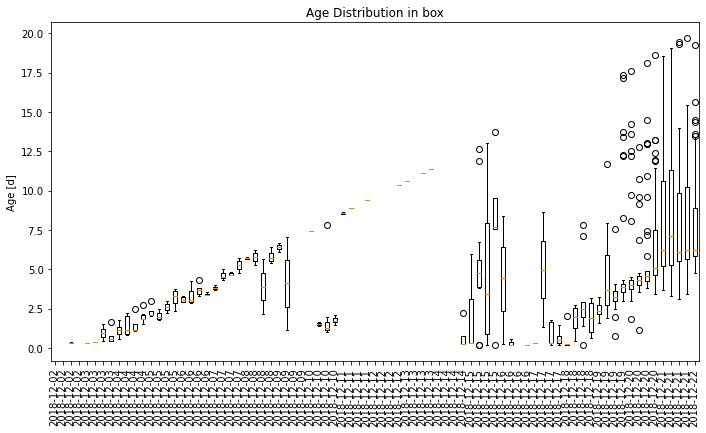

In [243]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0.03, 0.03, 0.90, 0.94], title='Age Distribution in box')

ax.boxplot(ages,labels=labels)
plt.xticks(rotation='vertical')
ax.set_ylabel('Age [d]')


In [ ]:
from matplotlib.animation import FuncAnimation

# %%capture
fig2 = plt.figure(figsize=(10,10))

ax1 = start_axes('Large', fig=fig2,sp='221', extent=[28, 29.5, 43, 44.5])
ax2 = start_axes('Zoom', fig=fig2,sp='222', extent=[28.6, 28.9, 43.9, 44.5])
ax3 = fig2.add_subplot('212')

time_id = np.where(data_xarray['time'] == timerange[0]) # Indices of the data where time = 0
scat1 = ax1.scatter(data_xarray['lon'].values[time_id],
                     data_xarray['lat'].values[time_id],10,
                    time_since_release.transpose()[time_id], vmin=0,vmax=10)

#clb1 =plt.colorbar(scat1)
#clb1.ax.set_xlabel('Age [d]')

scat2 = ax2.scatter(data_xarray['lon'].values[time_id],
                     data_xarray['lat'].values[time_id],10,
                    time_since_release.transpose()[time_id], vmin=0,vmax=10)

fig2.subplots_adjust(right=0.8)
cbar_ax = fig2.add_axes([0.85, 0.15, 0.05, 0.7])
clb2 = fig2.colorbar(scat2, cax=cbar_ax)
clb2.ax.set_xlabel('Age [d]')

box3  = ax3.boxplot(partinbox(0), labels= [np.datetime_as_string(timerange[0], unit='h')])
ax3.tick_params(labelrotation=90)
ax3.set_ylabel('Age [d]')
ax3.set_xlim( np.datetime_as_string(timerange[0], unit='h') , np.datetime_as_string(timerange[-1], unit='h')     )

t = np.datetime_as_string(timerange[0], unit='m')
title = ax.set_title('Particles at t = '+t)

labels=[]
ages=[]

def animate(i):
    t = np.datetime_as_string(timerange[i], unit='m')
    title.set_text('Particles at t = '+t)
    
    time_id = np.where(data_xarray['time'] == timerange[i])
    scat1.set_offsets(np.c_[data_xarray['lon'].values[time_id], data_xarray['lat'].values[time_id]])
    scat1.set_array(time_since_release.transpose()[time_id])
    scat2.set_offsets(np.c_[data_xarray['lon'].values[time_id], data_xarray['lat'].values[time_id]])
    scat2.set_array(time_since_release.transpose()[time_id])
    
    ages.append(partinbox(i))
    labels.append(np.datetime_as_string(timerange[i], unit='D')) 
    ax3.cla()
    box3  = ax3.boxplot(ages, labels= labels)
    ax3.tick_params(labelrotation=90)
    ax3.set_ylabel('Age [d]')
    ax3.set_title('Age Distribution in box')
    
anim = FuncAnimation(fig2, animate, frames = len(timerange), interval=500)


In [ ]:
labels=[]
ages=[]

HTML(anim.to_jshtml())

In [ ]:
labels=[]
ages=[]
anim.save('003_aged.mp4', fps=5, extra_args=['-vcodec', 'libx264'])